In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
# sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")

In [3]:
import os
from os.path import join
import pickle as pkl
import torch
from easydict import EasyDict as edict
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import einops
import json


In [4]:
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
# vector graphics type
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [5]:
# from train_edm import create_model, edm_sampler, EDM
from edm_utils import edm_sampler_inpaint, create_edm, get_default_config
from rule_utils import get_rule_img, get_obj_list, get_rule_list
from rule_utils import check_consistent
from dataset_utils import train_data2attr_tsr,load_raw_data,load_PGM_abstract

### Plotting functions

In [6]:
import re
import pandas as pd

def parse_log_file(log_file_path):
    # Regular expression pattern to match the relevant information
    pattern = r'\[(.*?)\] \(step=(\d+)\) Train Loss: (\d+\.\d+), Train Steps/Sec: (\d+\.\d+)'
    # Initialize an empty list to store the data
    data = []
    with open(log_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            match = re.match(pattern, line)
            if match:
                timestamp, step, loss, steps_per_sec = match.groups()
                data.append({
                    'Timestamp': timestamp,
                    'Step': int(step),
                    'Train Loss': float(loss),
                    'Train Steps/Sec': float(steps_per_sec)
                })
    # Create a pandas DataFrame from the data
    df = pd.DataFrame(data)
    return df

# Example usage
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
expdir = join(exproot, '032-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240308-1400')
log_file_path = join(expdir, "log.txt")
df = parse_log_file(log_file_path)
print(df.head())

                      Timestamp  Step  Train Loss  Train Steps/Sec
0  2024-03-08 14:01:45   100      0.6774            11.73
1  2024-03-08 14:01:47   200      0.1901            39.59
2  2024-03-08 14:01:50   300      0.1755            39.60
3  2024-03-08 14:01:52   400      0.1699            39.60
4  2024-03-08 14:01:55   500      0.1677            36.40


In [7]:
import json
from stats_plot_utils import estimate_CI, shaded_error

def visualize_consistency(epoch_list, consistent_mat, title_str="Wide Dep x3 Blnr", ax=None ):
    sample_size = consistent_mat.shape[1]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    else:
        fig = ax.figure
    ax.spines[['right', 'top']].set_visible(False)
    CI_low, CI_high = estimate_CI((consistent_mat == 1).sum(axis=1), sample_size, alpha=0.05)
    shaded_error(ax, epoch_list, (consistent_mat == 1).mean(axis=1),
                    CI_low, CI_high, label="Same in 3 rows", color="C0")
    CI_low, CI_high = estimate_CI((consistent_mat == 2).sum(axis=1), sample_size, alpha=0.05)
    shaded_error(ax, epoch_list, (consistent_mat==2).mean(axis=1),
                    CI_low, CI_high, label="Same in 2 rows", color="C1")
    ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_title(f"{title_str} Diffusion")
    ax.legend()
    # fig.savefig(join(figdir,f"{figname}_rule_consistency.pdf"), dpi=300, )#bbox_inches='tight')
    # fig.savefig(join(figdir,f"{figname}_rule_consistency.png"), dpi=300, )#bbox_inches='tight')
    return fig
    
    
def visualize_rule_validity(epoch_list, rules_all, title_str="Wide Dep x3 Blnr", ax=None ):
    sample_size = rules_all.shape[1]
    row_num = rules_all.shape[2]
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    else:
        fig = ax.figure
    ax.spines[['right', 'top']].set_visible(False)
    CI_low, CI_high = estimate_CI((rules_all != -1).sum(axis=(1,2)), sample_size * row_num, alpha=0.05)
    shaded_error(ax, epoch_list, (rules_all != -1).mean(axis=(1,2)),
                    CI_low, CI_high, label="valid row", color="C2")
    ax.set_ylabel('frac of valid rule\n among all rows', fontsize=14)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_title(f"{title_str} Diffusion")
    ax.legend()
    # fig.savefig(join(figdir,f"{figname}_rule_valid.pdf"), dpi=300, )#bbox_inches='tight')
    # fig.savefig(join(figdir,f"{figname}_rule_valid.png"), dpi=300, )#bbox_inches='tight')
    return fig


### Older rule dataset

In [8]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
sorted(os.listdir(exproot))


['000-RAVEN10_abstract-DiT_S_1',
 '001-RAVEN10_abstract-DiT_B_1',
 '002-RAVEN10_abstract-DiT_S_1',
 '003-RAVEN10_abstract_onehot-DiT_S_1',
 '004-RAVEN10_abstract-DiT_S_1',
 '005-RAVEN10_abstract_onehot-DiT_S_1',
 '006-RAVEN10_abstract-DiT_S_1',
 '007-RAVEN10_abstract_onehot-DiT_S_1',
 '008-RAVEN10_abstract-DiT_S_3',
 '009-RAVEN10_abstract-DiT_S_1',
 '010-RAVEN10_abstract-DiT_L_1',
 '011-RAVEN10_abstract-DiT_B_1',
 '012-RAVEN10_abstract-DiT_B_3',
 '013-RAVEN10_abstract-DiT_S_3',
 '014-RAVEN10_abstract_onehot-DiT_S_3',
 '015-RAVEN10_abstract_onehot-DiT_B_3',
 '016-RAVEN10_abstract-DiT_S_3',
 '017-RAVEN10_abstract_onehot-DiT_S_1',
 '018-RAVEN10_abstract-DiT_S_1',
 '019-RAVEN10_abstract_onehot-DiT_S_1',
 '020-RAVEN10_abstract-DiT_S_1',
 '021-RAVEN10_abstract-uncond-DiT_S_3_20240308-1349',
 '022-RAVEN10_abstract_onehot-uncond-DiT_B_3_20240308-1349',
 '023-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240308-1349',
 '024-RAVEN10_abstract-uncond-DiT_B_3_20240308-1349',
 '025-RAVEN10_abstract_oneho

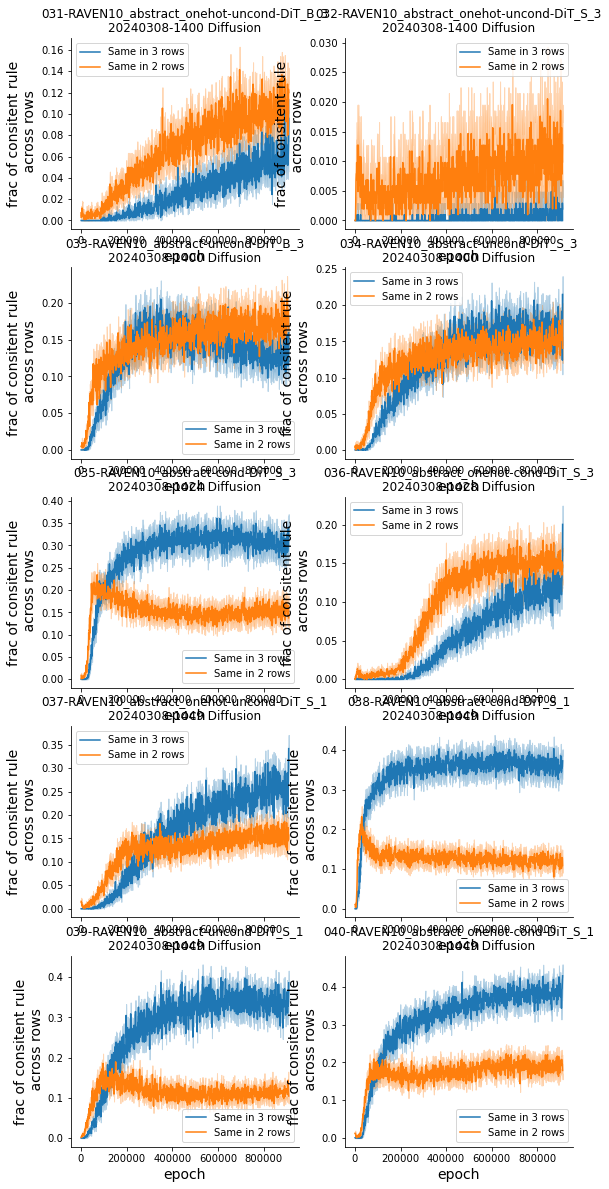

In [9]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figh, axs = plt.subplots(5, 2, figsize=(9, 20))
axs = axs.flatten()
for expi, expname in enumerate(['031-RAVEN10_abstract_onehot-uncond-DiT_B_3_20240308-1400',
                '032-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240308-1400',
                '033-RAVEN10_abstract-uncond-DiT_B_3_20240308-1400',
                '034-RAVEN10_abstract-uncond-DiT_S_3_20240308-1400',
                '035-RAVEN10_abstract-cond-DiT_S_3_20240308-1424',
                '036-RAVEN10_abstract_onehot-cond-DiT_S_3_20240308-1428',
                '037-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240308-1449',
                '038-RAVEN10_abstract-cond-DiT_S_1_20240308-1449',
                '039-RAVEN10_abstract-uncond-DiT_S_1_20240308-1449',
                '040-RAVEN10_abstract_onehot-cond-DiT_S_1_20240308-1449',]):
    expdir = join(exproot, expname)
    args = json.load(open(join(expdir, "args.json")))
    rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency.npz'))
    log_df = parse_log_file(join(expdir, "log.txt"))
    consistent_mat = rule_data['consistent_mat']
    rules_all = rule_data['rules_all']
    epoch_list = rule_data['epoch_list']
    # print(os.listdir(expdir))
    # print(log_df.head())
    visualize_consistency(epoch_list, consistent_mat, 
                        title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],)
    # visualize_rule_validity(epoch_list, rules_all, 
    #                         title_str=expname, ax=axs[expi],);
    # raise NotImplementedError
    # df = parse_train_logfile(join(expdir, "std.log"))
    # # df.tail()
    # df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75) 
    # plt.title(expname)
    # plt.show()

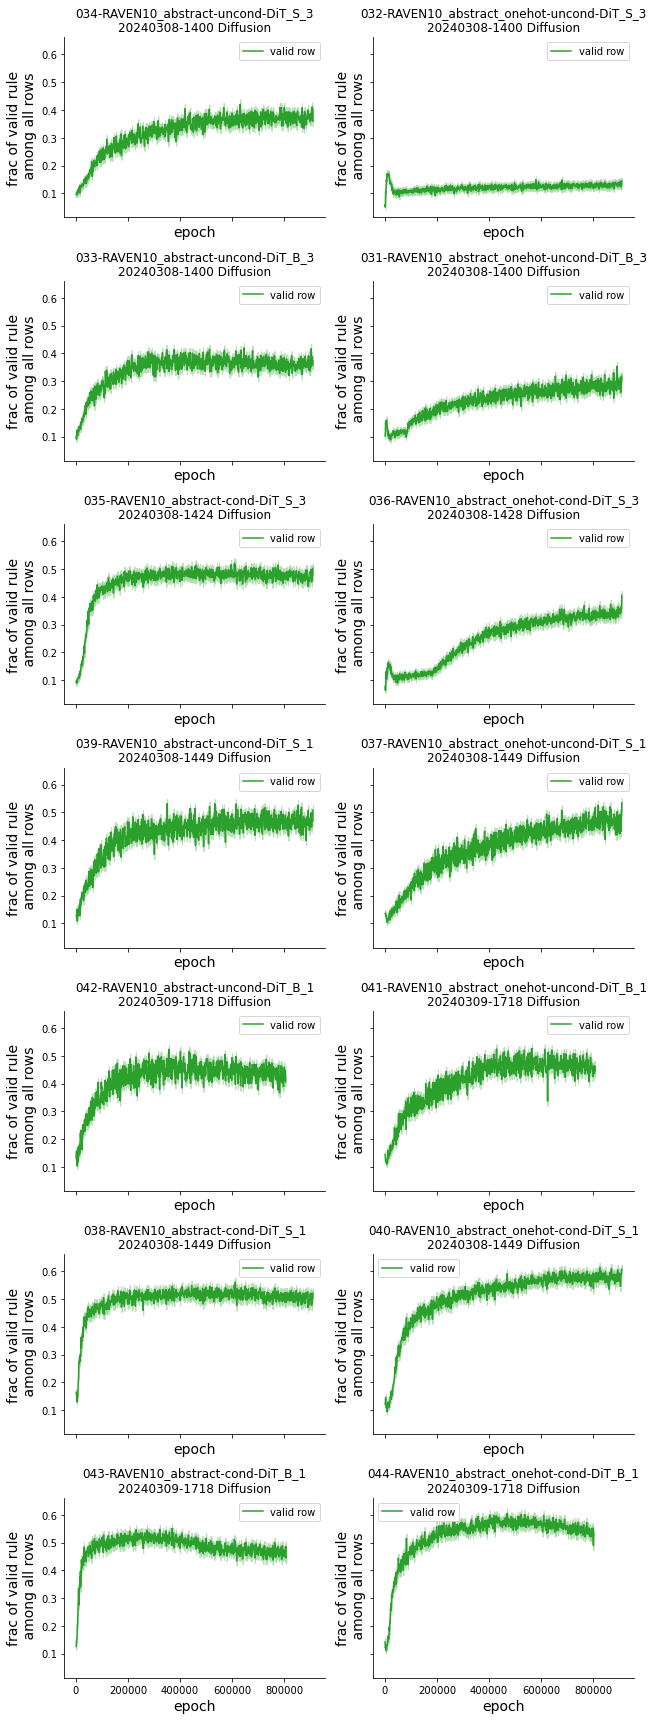

In [10]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figh, axs = plt.subplots(7, 2, figsize=(9, 24), sharex=True, sharey=True)
axs = axs.flatten()
for expi, expname in enumerate([
                '034-RAVEN10_abstract-uncond-DiT_S_3_20240308-1400',
                '032-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240308-1400',
                '033-RAVEN10_abstract-uncond-DiT_B_3_20240308-1400',
                '031-RAVEN10_abstract_onehot-uncond-DiT_B_3_20240308-1400',
                '035-RAVEN10_abstract-cond-DiT_S_3_20240308-1424',
                '036-RAVEN10_abstract_onehot-cond-DiT_S_3_20240308-1428',
                '039-RAVEN10_abstract-uncond-DiT_S_1_20240308-1449',
                '037-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240308-1449',
                '042-RAVEN10_abstract-uncond-DiT_B_1_20240309-1718',
                '041-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240309-1718',
                '038-RAVEN10_abstract-cond-DiT_S_1_20240308-1449',
                '040-RAVEN10_abstract_onehot-cond-DiT_S_1_20240308-1449',
                '043-RAVEN10_abstract-cond-DiT_B_1_20240309-1718',
                '044-RAVEN10_abstract_onehot-cond-DiT_B_1_20240309-1718']):
    expdir = join(exproot, expname)
    args = json.load(open(join(expdir, "args.json")))
    rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency.npz'))
    log_df = parse_log_file(join(expdir, "log.txt"))
    consistent_mat = rule_data['consistent_mat']
    rules_all = rule_data['rules_all']
    epoch_list = rule_data['epoch_list']
    # visualize_consistency(epoch_list, consistent_mat, 
    #                     title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],)
    visualize_rule_validity(epoch_list, rules_all, 
                title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],);
    # df = parse_train_logfile(join(expdir, "std.log"))
    # # df.tail()
    # df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75) 
    # plt.title(expname)
    # plt.show()
figh.tight_layout()
figh.show()

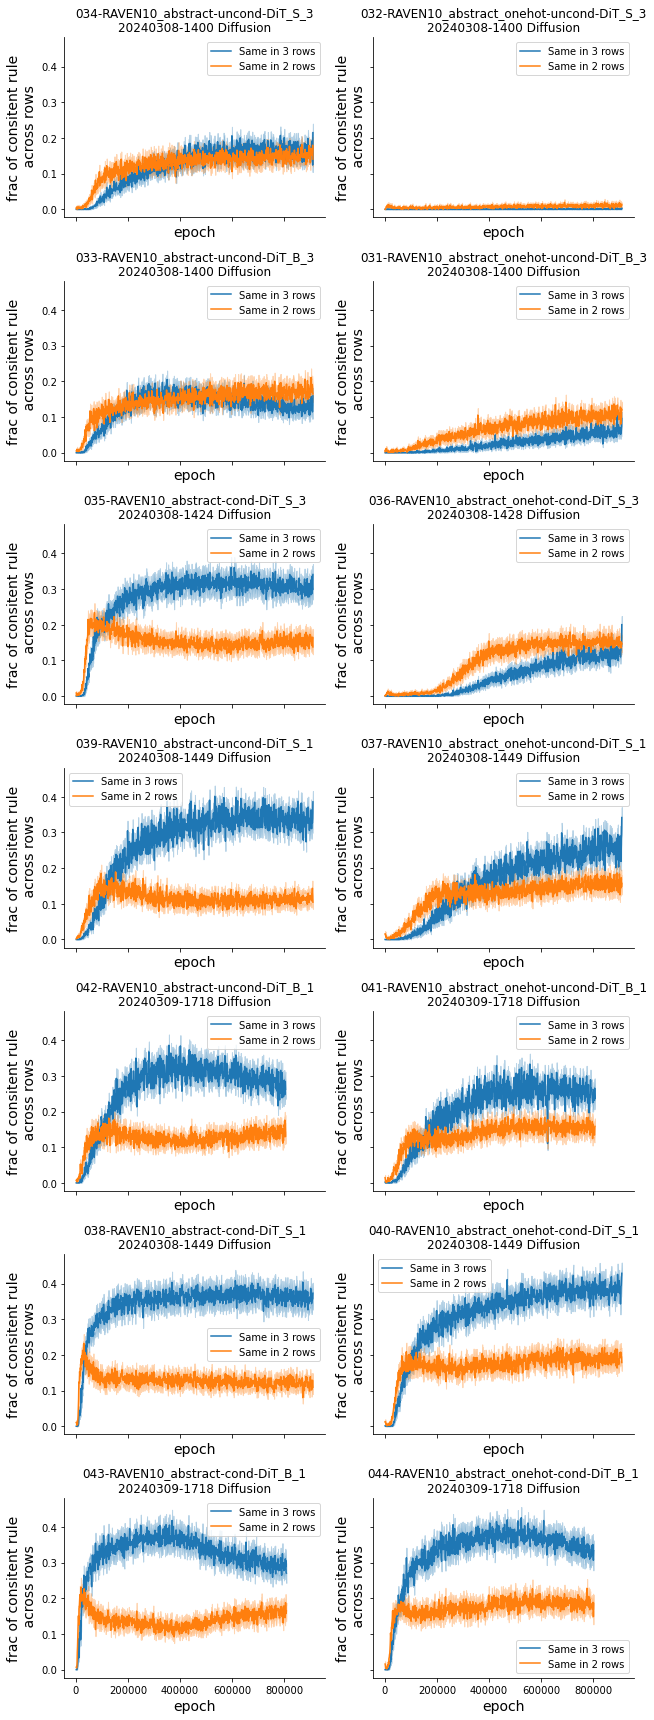

In [11]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figh, axs = plt.subplots(7, 2, figsize=(9, 24), sharex=True, sharey=True)
axs = axs.flatten()
for expi, expname in enumerate([
                '034-RAVEN10_abstract-uncond-DiT_S_3_20240308-1400',
                '032-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240308-1400',
                '033-RAVEN10_abstract-uncond-DiT_B_3_20240308-1400',
                '031-RAVEN10_abstract_onehot-uncond-DiT_B_3_20240308-1400',
                '035-RAVEN10_abstract-cond-DiT_S_3_20240308-1424',
                '036-RAVEN10_abstract_onehot-cond-DiT_S_3_20240308-1428',
                '039-RAVEN10_abstract-uncond-DiT_S_1_20240308-1449',
                '037-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240308-1449',
                '042-RAVEN10_abstract-uncond-DiT_B_1_20240309-1718',
                '041-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240309-1718',
                '038-RAVEN10_abstract-cond-DiT_S_1_20240308-1449',
                '040-RAVEN10_abstract_onehot-cond-DiT_S_1_20240308-1449',
                '043-RAVEN10_abstract-cond-DiT_B_1_20240309-1718',
                '044-RAVEN10_abstract_onehot-cond-DiT_B_1_20240309-1718']):
    expdir = join(exproot, expname)
    args = json.load(open(join(expdir, "args.json")))
    rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency.npz'))
    log_df = parse_log_file(join(expdir, "log.txt"))
    consistent_mat = rule_data['consistent_mat']
    rules_all = rule_data['rules_all']
    epoch_list = rule_data['epoch_list']
    visualize_consistency(epoch_list, consistent_mat, 
                        title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],)
    # visualize_rule_validity(epoch_list, rules_all, 
    #             title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],);
    # df = parse_train_logfile(join(expdir, "std.log"))
    # # df.tail()
    # df.plot(x="step", y=["average_loss","batch_loss"], alpha=0.75) 
    # plt.title(expname)
    # plt.show()
figh.tight_layout()
figh.show()

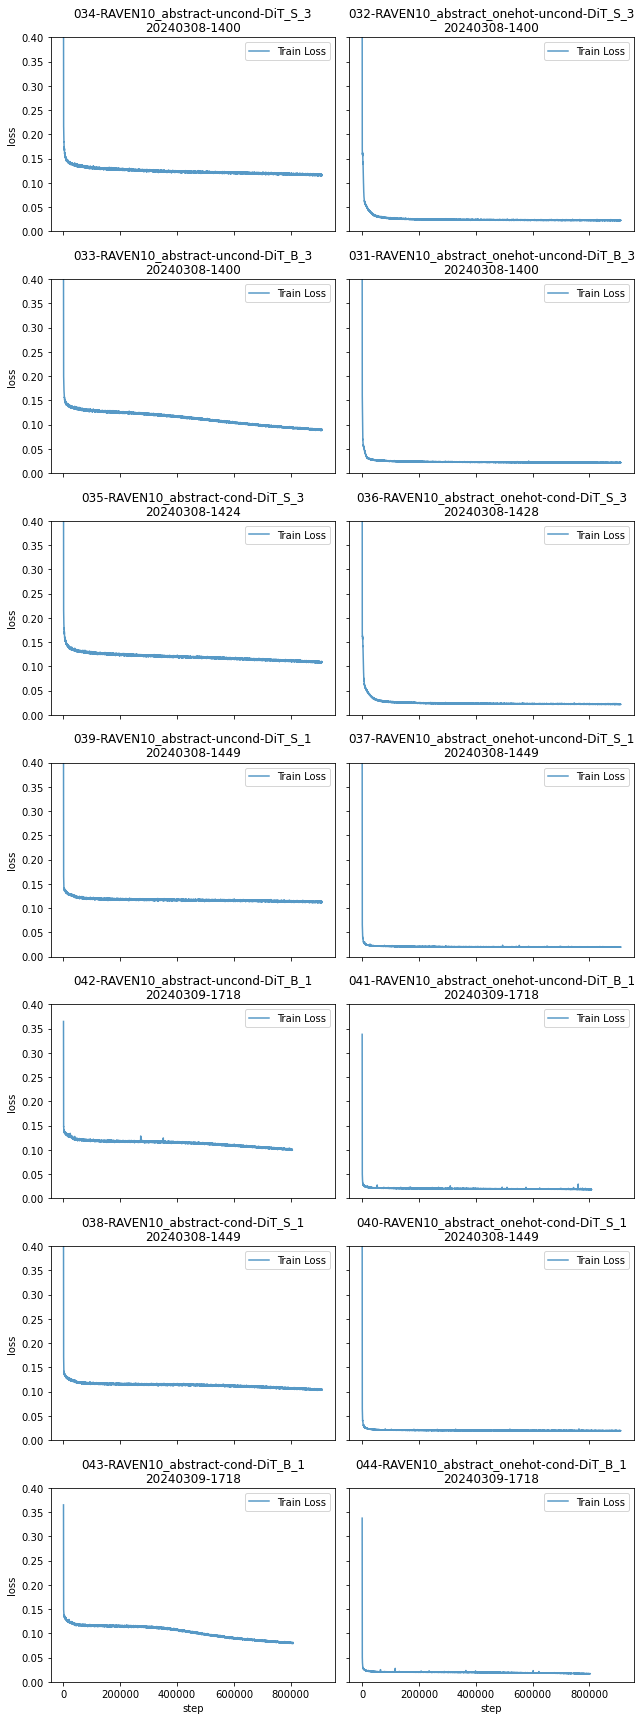

In [12]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figh, axs = plt.subplots(7, 2, figsize=(9, 24), sharex=True, sharey=True)
axs = axs.flatten()
for expi, expname in enumerate([
                '034-RAVEN10_abstract-uncond-DiT_S_3_20240308-1400',
                '032-RAVEN10_abstract_onehot-uncond-DiT_S_3_20240308-1400',
                '033-RAVEN10_abstract-uncond-DiT_B_3_20240308-1400',
                '031-RAVEN10_abstract_onehot-uncond-DiT_B_3_20240308-1400',
                '035-RAVEN10_abstract-cond-DiT_S_3_20240308-1424',
                '036-RAVEN10_abstract_onehot-cond-DiT_S_3_20240308-1428',
                '039-RAVEN10_abstract-uncond-DiT_S_1_20240308-1449',
                '037-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240308-1449',
                '042-RAVEN10_abstract-uncond-DiT_B_1_20240309-1718',
                '041-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240309-1718',
                '038-RAVEN10_abstract-cond-DiT_S_1_20240308-1449',
                '040-RAVEN10_abstract_onehot-cond-DiT_S_1_20240308-1449',
                '043-RAVEN10_abstract-cond-DiT_B_1_20240309-1718',
                '044-RAVEN10_abstract_onehot-cond-DiT_B_1_20240309-1718']):
    expdir = join(exproot, expname)
    args = json.load(open(join(expdir, "args.json")))
    rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency.npz'))
    log_df = parse_log_file(join(expdir, "log.txt"))
    consistent_mat = rule_data['consistent_mat']
    rules_all = rule_data['rules_all']
    epoch_list = rule_data['epoch_list']
    # visualize_consistency(epoch_list, consistent_mat, 
    #                     title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],)
    # visualize_rule_validity(epoch_list, rules_all, 
    #             title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],);
    log_df.plot(x="Step", y=["Train Loss"], alpha=0.75, ax=axs[expi]) 
    axs[expi].set_title(expname.replace("_2024", "\n2024"))
    axs[expi].set_xlabel('step')
    axs[expi].set_ylabel('loss')
    axs[expi].set_ylim(0.00, 0.4)
    
figh.tight_layout()
figh.show()

### New Rule synopsis

In [13]:
def visualize_consistency_new(stats_df, title_str="Wide Dep x3 Blnr", ax=None ):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    ax.spines[['right', 'top']].set_visible(False)
    CI_low, CI_high = estimate_CI(stats_df.r3_count, stats_df.sample_count, alpha=0.05)
    shaded_error(ax, stats_df.epoch, stats_df.r3_count / stats_df.sample_count,
                    CI_low, CI_high, label="Same in 3 rows", color="C0")
    CI_low, CI_high = estimate_CI(stats_df.r2_count, stats_df.sample_count, alpha=0.05)
    shaded_error(ax, stats_df.epoch, stats_df.r2_count / stats_df.sample_count,
                    CI_low, CI_high, label="Same in 2 rows", color="C1")
    ax.set_ylabel('frac of consitent rule\n across rows', fontsize=14)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_title(f"{title_str}") # , uncond Diffusion
    ax.legend()
    # if figdir is not None:
    #     fig.savefig(join(figdir, f"{figname}_new_rule_consistency.pdf"), dpi=300, )#bbox_inches='tight')
    #     fig.savefig(join(figdir, f"{figname}_new_rule_consistency.png"), dpi=300, )#bbox_inches='tight')
    return ax
    
    
def visualize_rule_validity_new(stats_df, title_str="Wide Dep x3 Blnr", ax=None, ):
    row_num = 3
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    ax.spines[['right', 'top']].set_visible(False)
    CI_low, CI_high = estimate_CI(stats_df.valid_count, 
                                  stats_df.sample_count * row_num, alpha=0.05)
    shaded_error(ax, stats_df.epoch, stats_df.valid_count / stats_df.sample_count / row_num,
                    CI_low, CI_high, label="valid row", color="C2")
    ax.set_ylabel('frac of valid rule\n among all rows', fontsize=14)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_title(f"{title_str}") # , uncond Diffusion
    ax.legend()
    # if figdir is not None:
    #     fig.savefig(join(figdir,f"{figname}_new_rule_valid.pdf"), dpi=300, )#bbox_inches='tight')
    #     fig.savefig(join(figdir,f"{figname}_new_rule_valid.png"), dpi=300, )#bbox_inches='tight')
    return ax

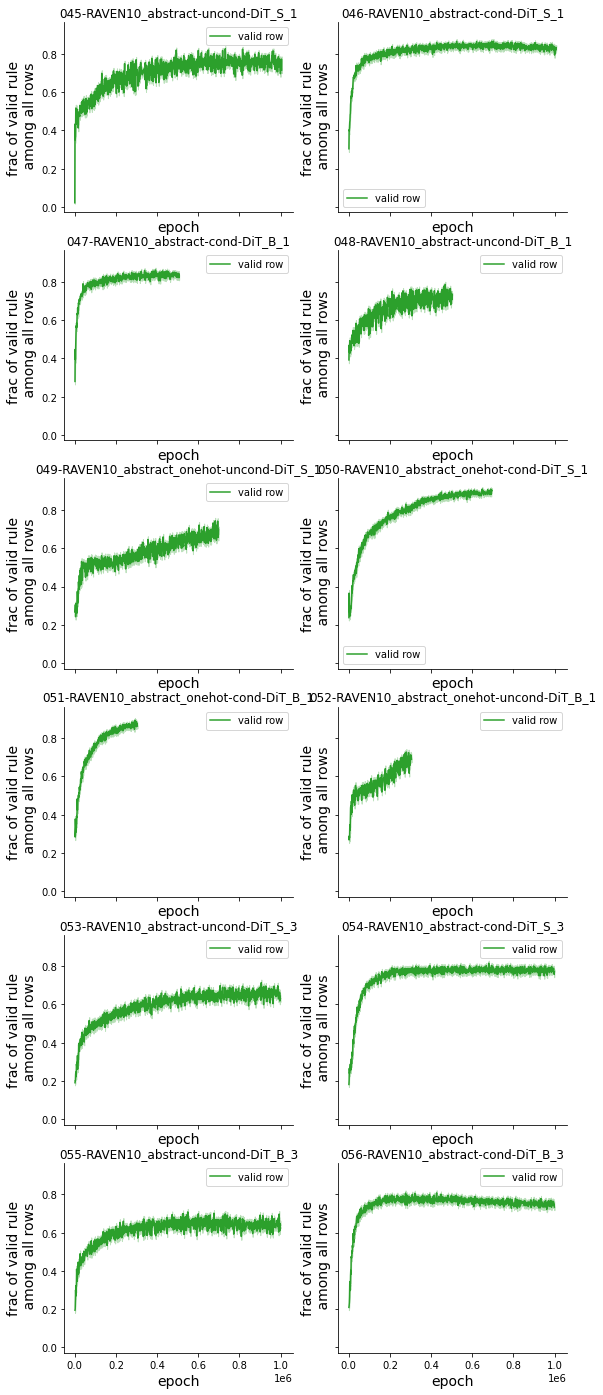

In [17]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figh, axs = plt.subplots(6, 2, figsize=(9, 24), sharex=True, sharey=True)
axs = axs.flatten()
for expi, expname in enumerate(['045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256',
                                '046-RAVEN10_abstract-cond-DiT_S_1_20240311-1256',
                                '047-RAVEN10_abstract-cond-DiT_B_1_20240311-1259',
                                '048-RAVEN10_abstract-uncond-DiT_B_1_20240311-1259',
                                '049-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240312-0219',
                                '050-RAVEN10_abstract_onehot-cond-DiT_S_1_20240312-0219',
                                '051-RAVEN10_abstract_onehot-cond-DiT_B_1_20240312-0222',
                                '052-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240312-0222',
                                '053-RAVEN10_abstract-uncond-DiT_S_3_20240312-0231',
                                '054-RAVEN10_abstract-cond-DiT_S_3_20240312-0233',
                                '055-RAVEN10_abstract-uncond-DiT_B_3_20240312-0233',
                                '056-RAVEN10_abstract-cond-DiT_B_3_20240312-0235']):
    expdir = join(exproot, expname)
    args = json.load(open(join(expdir, "args.json")))
    rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency_new.npz'))
    log_df = parse_log_file(join(expdir, "log.txt"))
    stats_df = pd.read_csv(join(expdir, "consistency_new_stats_df.csv"))
    # log_df.plot(x="Step", y=["Train Loss"], alpha=0.75, ax=axs[expi])
    # visualize_consistency_new(stats_df, title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],)
    visualize_rule_validity_new(stats_df, title_str=expname.split("_2024")[0], ax=axs[expi],);
    

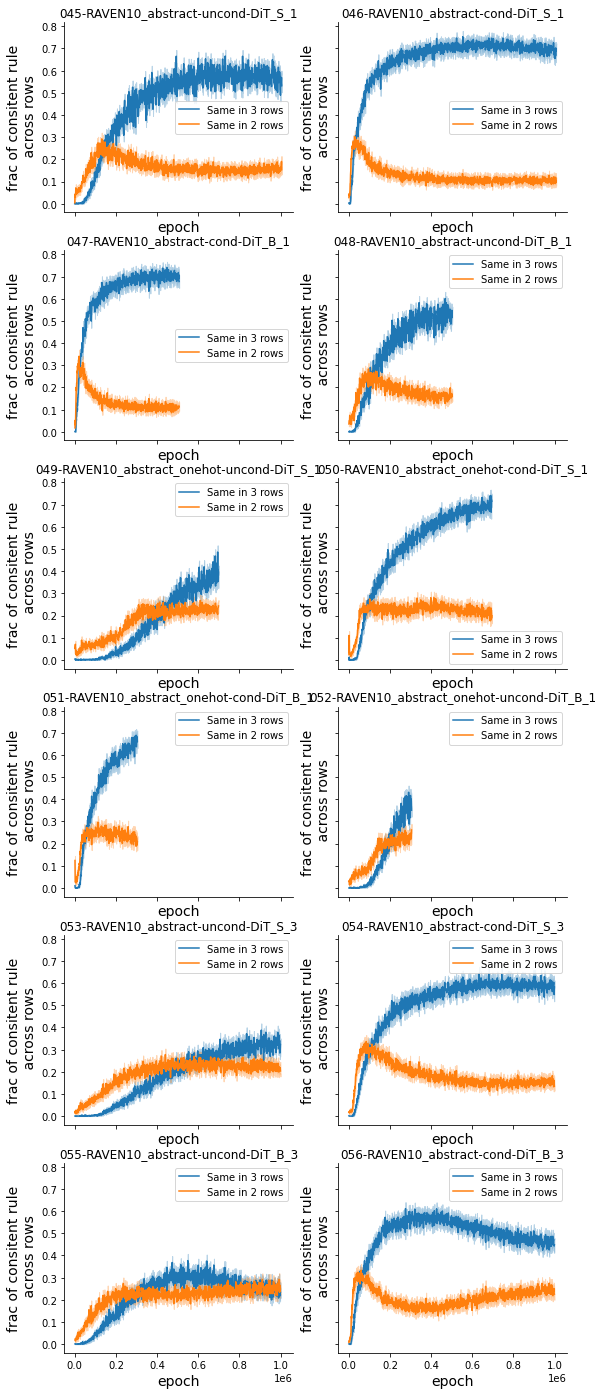

In [18]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figh, axs = plt.subplots(6, 2, figsize=(9, 24), sharex=True, sharey=True)
axs = axs.flatten()
for expi, expname in enumerate(['045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256',
                                '046-RAVEN10_abstract-cond-DiT_S_1_20240311-1256',
                                '047-RAVEN10_abstract-cond-DiT_B_1_20240311-1259',
                                '048-RAVEN10_abstract-uncond-DiT_B_1_20240311-1259',
                                '049-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240312-0219',
                                '050-RAVEN10_abstract_onehot-cond-DiT_S_1_20240312-0219',
                                '051-RAVEN10_abstract_onehot-cond-DiT_B_1_20240312-0222',
                                '052-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240312-0222',
                                '053-RAVEN10_abstract-uncond-DiT_S_3_20240312-0231',
                                '054-RAVEN10_abstract-cond-DiT_S_3_20240312-0233',
                                '055-RAVEN10_abstract-uncond-DiT_B_3_20240312-0233',
                                '056-RAVEN10_abstract-cond-DiT_B_3_20240312-0235']):
    expdir = join(exproot, expname)
    args = json.load(open(join(expdir, "args.json")))
    rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency_new.npz'))
    log_df = parse_log_file(join(expdir, "log.txt"))
    stats_df = pd.read_csv(join(expdir, "consistency_new_stats_df.csv"))
    # log_df.plot(x="Step", y=["Train Loss"], alpha=0.75, ax=axs[expi])
    visualize_consistency_new(stats_df, title_str=expname.split("_2024")[0], ax=axs[expi],)
    # visualize_rule_validity_new(stats_df, title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],);
    

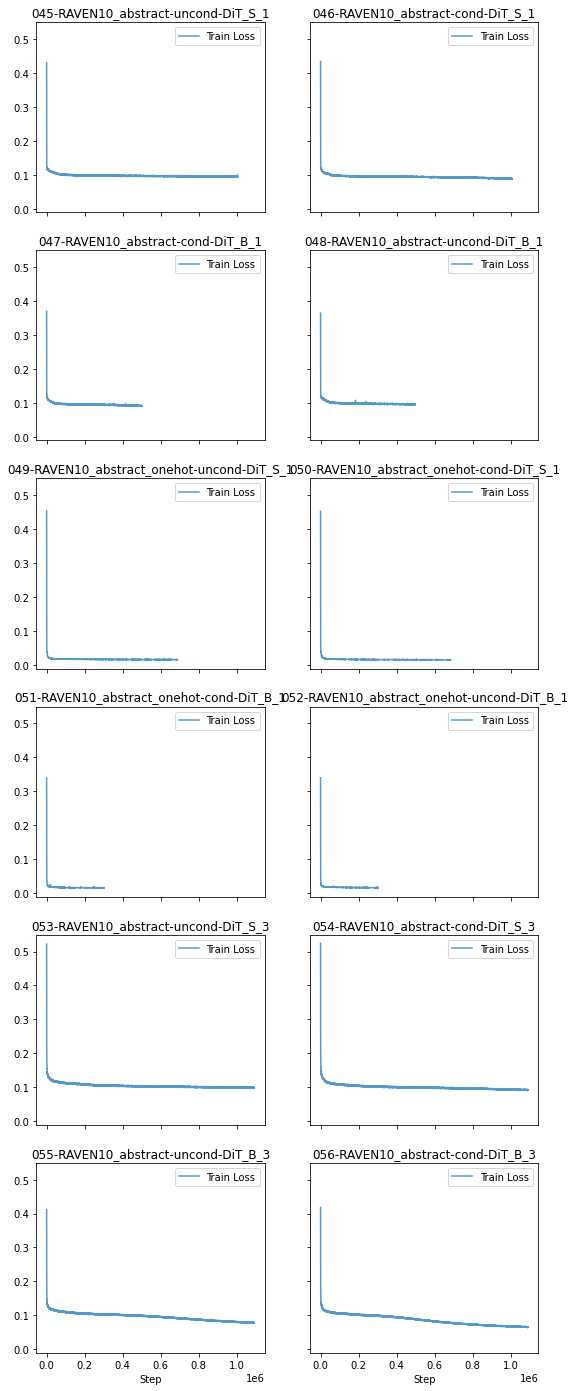

In [26]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
figh, axs = plt.subplots(6, 2, figsize=(9, 24), sharex=True, sharey=True)
axs = axs.flatten()
for expi, expname in enumerate(['045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256',
                                '046-RAVEN10_abstract-cond-DiT_S_1_20240311-1256',
                                '047-RAVEN10_abstract-cond-DiT_B_1_20240311-1259',
                                '048-RAVEN10_abstract-uncond-DiT_B_1_20240311-1259',
                                '049-RAVEN10_abstract_onehot-uncond-DiT_S_1_20240312-0219',
                                '050-RAVEN10_abstract_onehot-cond-DiT_S_1_20240312-0219',
                                '051-RAVEN10_abstract_onehot-cond-DiT_B_1_20240312-0222',
                                '052-RAVEN10_abstract_onehot-uncond-DiT_B_1_20240312-0222',
                                '053-RAVEN10_abstract-uncond-DiT_S_3_20240312-0231',
                                '054-RAVEN10_abstract-cond-DiT_S_3_20240312-0233',
                                '055-RAVEN10_abstract-uncond-DiT_B_3_20240312-0233',
                                '056-RAVEN10_abstract-cond-DiT_B_3_20240312-0235']):
    expdir = join(exproot, expname)
    args = json.load(open(join(expdir, "args.json")))
    rule_data = np.load(join(expdir, 'samples_inferred_rule_consistency_new.npz'))
    log_df = parse_log_file(join(expdir, "log.txt"))
    stats_df = pd.read_csv(join(expdir, "consistency_new_stats_df.csv"))
    log_df.plot(x="Step", y=["Train Loss"], alpha=0.75, ax=axs[expi])
    axs[expi].set_title(expname.split("_2024")[0])
    # visualize_consistency_new(stats_df, title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],)
    # visualize_rule_validity_new(stats_df, title_str=expname.replace("_2024", "\n2024"), ax=axs[expi],);
    